# Result of time-domain inference on fiducial BBH injection with IMRPhenomXPHM

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify, h5py
import bilby
import scipy.linalg as sl
from scipy.stats import norm, gaussian_kde
import shutil
from tqdm import tqdm
import lal
import json

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
cmap1 = sns.color_palette('colorblind')
cmap2 = sns.color_palette('dark')

import sys, os
sys.path.append('/home/simona.miller/time-domain-gw-inference')
from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result
Load in the time-domain inference result using the functionality of `group_postprocess`.

In [2]:
def load_TD_results(run): 

    # Load in the result
    result = group_postprocess.load_run_settings_from_directory(
        'output/'+run,
        filename_dict={'full':'full_0.0seconds'}
    )
    
    # Likelihood manager 
    lm = result['runs']['full']['likelihood_manager']  
    
    # Extract the posterior
    posterior = result['dfs']['full']

    # To match bilby convention
    posterior['polarization'] = posterior['polarization'] % np.pi
    posterior['phase'] = np.where(posterior['phase'] < 0, posterior['phase'] + 2 * np.pi, posterior['phase'])

    # Needed for prior reweighting later
    posterior['chirp_mass'] = utils.get_chirpmass(posterior['mass1'], posterior['mass2'])

    return posterior, result, lm 

run = '250805_output'
TD_posterior, TD_result, lm = load_TD_results(run)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


In [3]:
# Get reference parameters
with open('./input/injection.json') as f:
    reference_parameters = json.load(f)

# Transform param names to match TD code
reference_parameters_transformed = run_sampler.modify_parameters(
    reference_parameters, TD_result['runs']['full']['args']
)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


Load in the `bilby` result for comparison.

In [4]:
FD_posterior = np.genfromtxt('./input/new_XPHM_standard_pesummary.dat', names=True)

### Prior reweighting
The two runs differ in the priors for masses, luminosity distance, and time. First, make a bilby prior object with some useful priors:

In [5]:
# # Extract prior
# from bilby.core.prior import PriorDict, PowerLaw
# from bilby.gw.prior import UniformInComponentsChirpMass

# _bilby_prior = FD_result['C01:IMRPhenomXPHM']['priors']['analytic']

# bilby_prior = bilby.core.prior.PriorDict()
# bilby_prior['luminosity_distance'] = eval(_bilby_prior['luminosity_distance'][0].decode(encoding='utf-8'))
# bilby_prior['chirp_mass'] = eval(_bilby_prior['chirp_mass'][0].decode(encoding='utf-8'))

# print(bilby_prior)

In [6]:
# # Jacobian between uniform in (M,q) <--> uniform in (m1,m2)
# def get_jacobian(m1, m2):
#     return m1**2/(m1+m2)

# # Calculate bilby prior weights on the TD samples for parameters of interest (masses, distance)
# p_bilby_masses = get_jacobian(TD_posterior['mass1'], TD_posterior['mass2'])
# p_bilby_DL =  bilby_prior['luminosity_distance'].prob(TD_posterior['luminosity_distance'])
# p_bilby = p_bilby_masses * p_bilby_DL

# # Calculate TD prior on the TD samples for parameters of interest (geocenter time) 
# p_TD = norm.pdf(TD_posterior['geocenter_time'], loc=lm.reference_time, scale=lm.sigma_time)

# # Reweight
# weights = p_bilby / p_TD

# # Hard cut on chirp mass
# td_mask = (TD_posterior['chirp_mass'] > bilby_prior['chirp_mass'].minimum) & (TD_posterior['chirp_mass'] < bilby_prior['chirp_mass'].maximum) 
# weights[~td_mask] = 0

# td_mask_2 = TD_posterior['mass_ratio'] < 0.4
# weights[td_mask_2] = 0

In [7]:
# # Calculate the effective number of samples
# from scipy.special import logsumexp
# logwts = np.log(weights)
# logneff = logsumexp(logwts) * 2 - logsumexp(logwts * 2)
# neff = np.exp(logneff)

# print('total samples:', len(weights))
# print('effective samples:', neff)

## Plot comparison

The two codes use different naming keys for the parameters, so we must set up a dictionary to translate between them:

In [8]:
# keys = bilby keys; values = TD keys
key_transform = {
    'mass_ratio':'mass_ratio', 
    'total_mass':'total_mass',
    'mass_1':'mass1',
    'mass_2':'mass2',
    'luminosity_distance':'luminosity_distance',
    'a_1':'spin1_magnitude',
    'a_2':'spin2_magnitude',
    'tilt_1':'tilt1',
    'tilt_2':'tilt2',
    'phi_12':'phi12',
    'phi_jl':'phi_jl',
    'theta_jn':'theta_jn',
    'ra':'right_ascension', 
    'dec':'declination',
    'psi':'polarization',
    'phase':'phase',
    'geocent_time':'geocenter_time'
}

In [9]:
# # make empty dict
# JSD_dict = {}

# # we care about masses and spins; there are slightly different naming conventions 
# # between the two codes
# param_names = ['total_mass', 'mass_ratio', 'mass1', 'mass2', 
#                'chi_effective', 'chi_precessing', 'spin1_magnitude', 'spin2_magnitude'] 
# param_names_bilby = ['total_mass', 'mass_ratio', 'mass_1', 'mass_2', 
#                      'chi_eff', 'chi_p', 'a_1', 'a_2'] 

# # cycle through parameters
# for pb,p in key_transform.items():

#     # calculate JSD
#     JSD = utils.calculate_js(
#         samplesA=FD_posterior[pb], 
#         samplesB=TD_posterior[p],
#         ntests=100, 
#         nsamples=int(neff/2)
#     )

#     JSD_rw = utils.calculate_js(
#         samplesA=FD_posterior[pb], 
#         samplesB=TD_posterior[p],
#         weightsB=weights/np.sum(weights),
#         ntests=100, 
#         nsamples=int(neff/2)
#     )

#     # print its information
#     JSD_str = f"JSD: {JSD.median * 1e3:0.1f}+{JSD.plus * 1e3:0.1f}-{JSD.minus * 1e3:0.1f} mb"
#     print(pb, JSD_str)

#     # add to dict
#     JSD_dict[pb] = {'td prior':JSD.median, 'fd prior':JSD_rw.median}

Generate comparison plot for the two posteriors

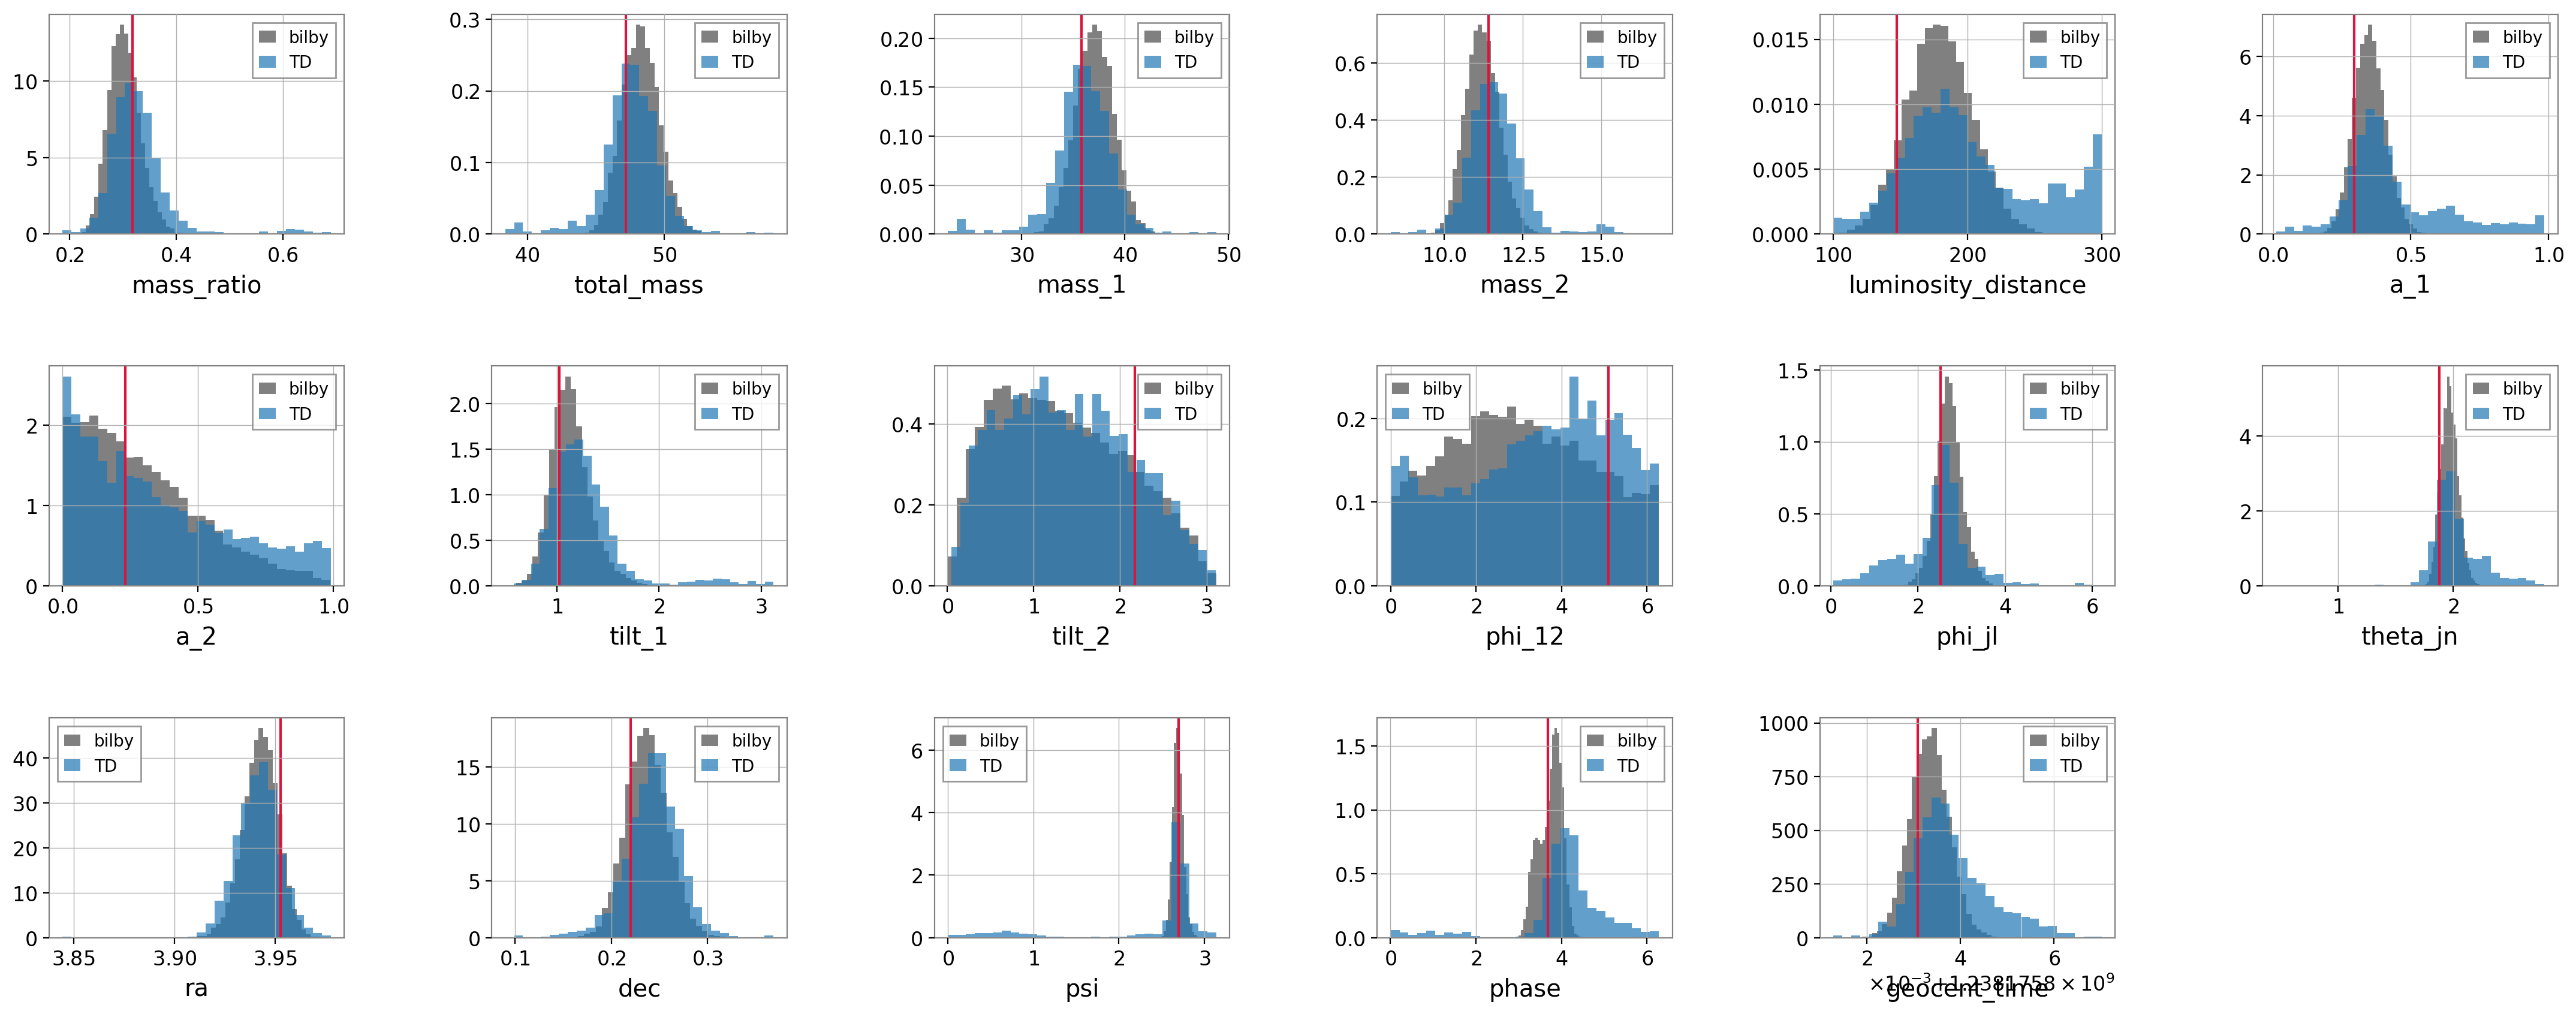

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    
    ax.hist(FD_posterior[k], **hist_kws, color='gray',label='bilby')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='TD')
    #ax.hist(TD_posterior[key_transform[k]], **hist_kws, weights=weights, histtype='step', color='navy', lw=2, label='TD, RW')
    
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

    ax.axvline(reference_parameters[k], color='crimson', label='inj')

    # JS = round(JSD_dict[k]['td prior']*1e3, 1)
    # JS_rw = round(JSD_dict[k]['fd prior']*1e3, 1)
    # ax.set_title('JSD '+str(JS)+' mb\n JSD, RW: '+str(JS_rw)+' mb', fontsize=12)
    
plt.subplots_adjust(hspace=0.6, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

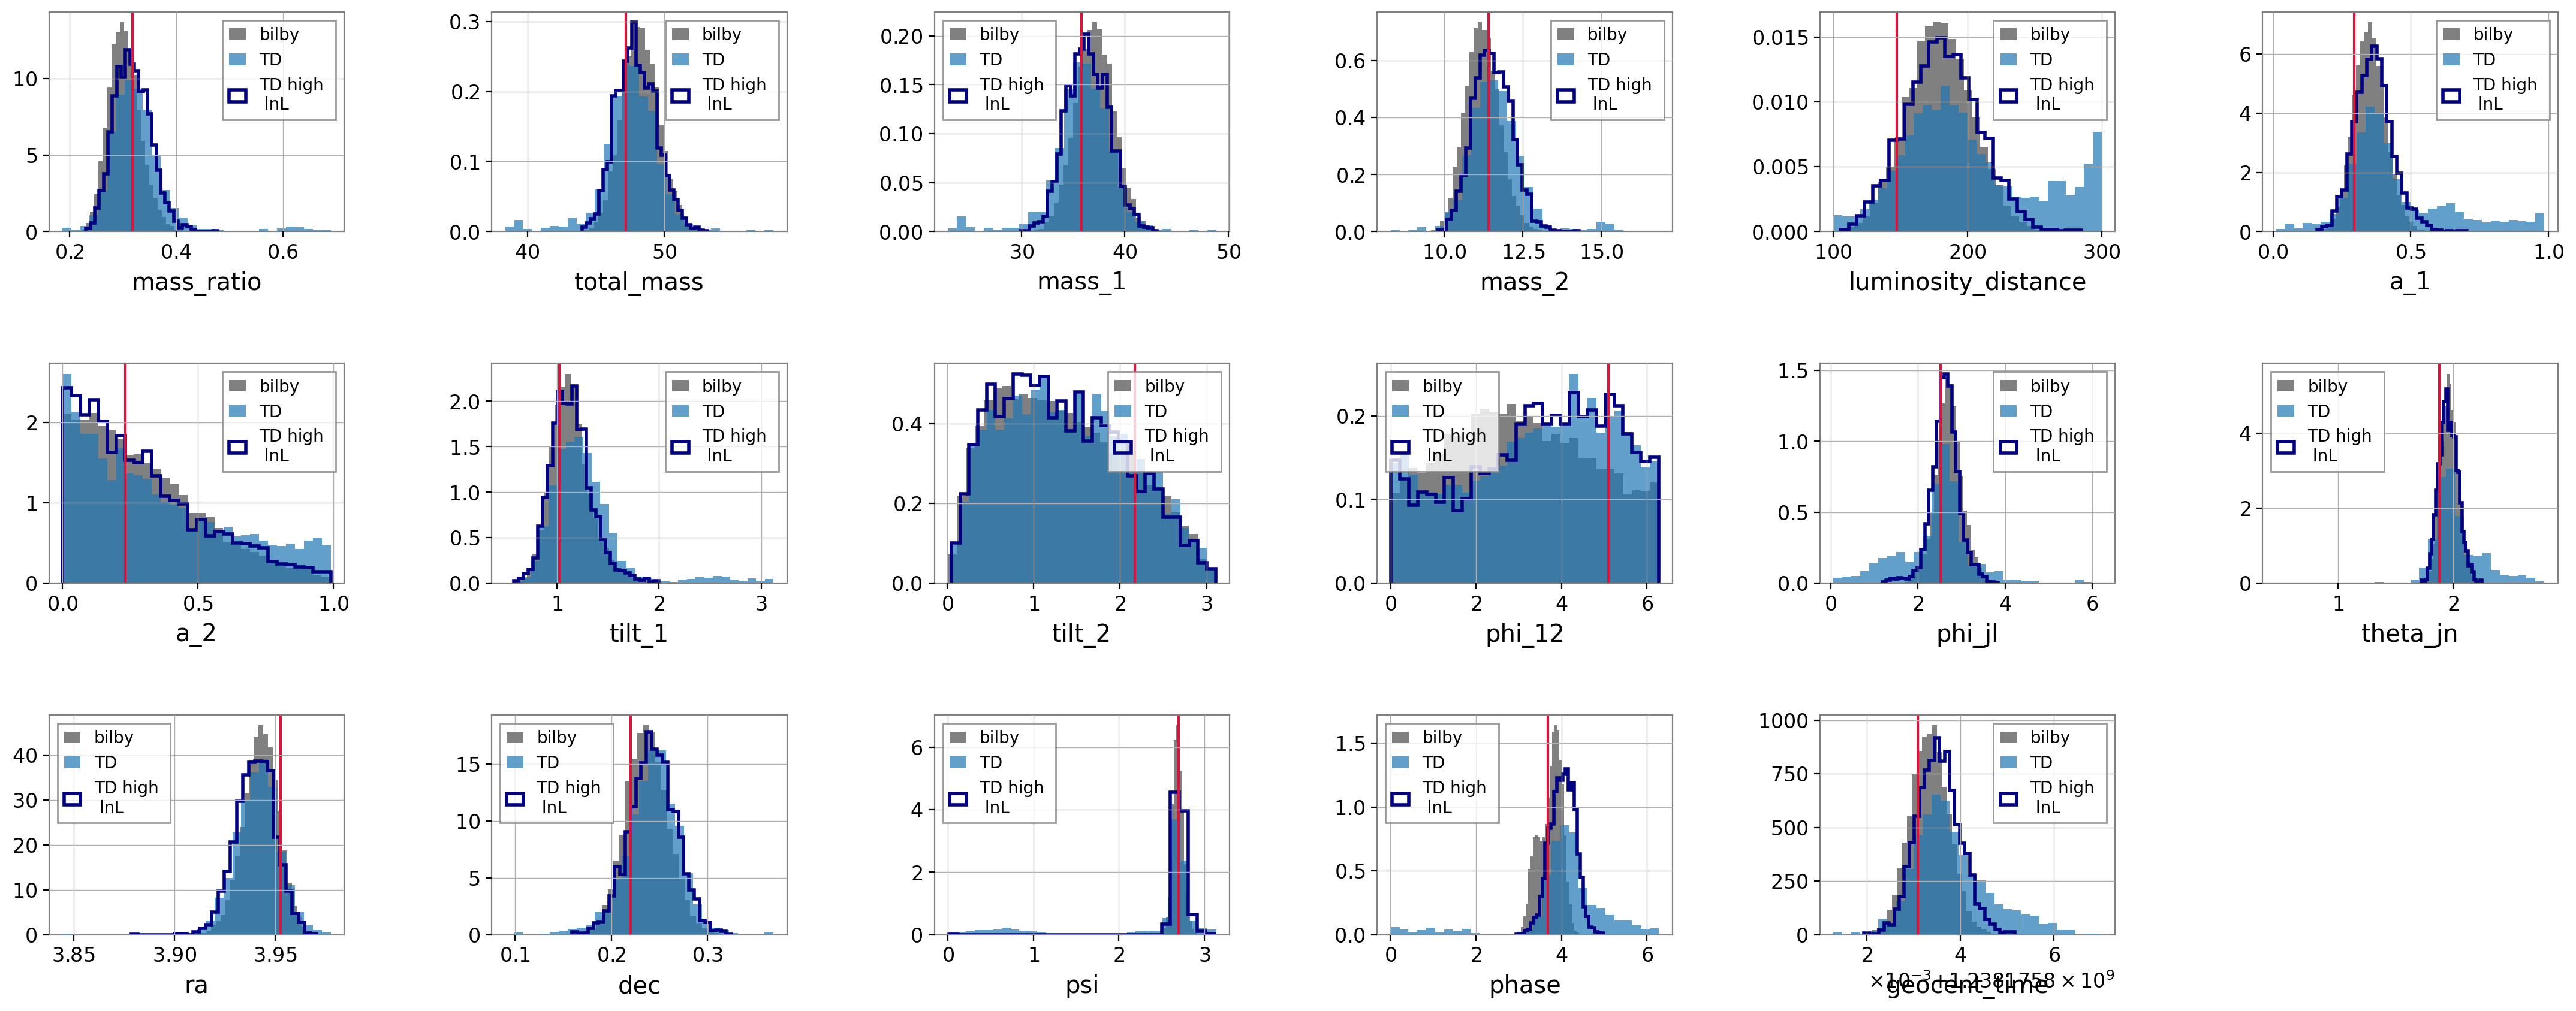

In [43]:
lnL_CUT = -3255
TD_mask = TD_posterior['ln_likelihood']>lnL_CUT

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    
    ax.hist(FD_posterior[k], **hist_kws, color='gray',label='bilby')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='TD')
    ax.hist(TD_posterior[key_transform[k]][TD_mask], **hist_kws, color='navy', histtype='step',  lw=2,label='TD high \n lnL')
    
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

    ax.axvline(reference_parameters[k], color='crimson', label='inj')
    
plt.subplots_adjust(hspace=0.6, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

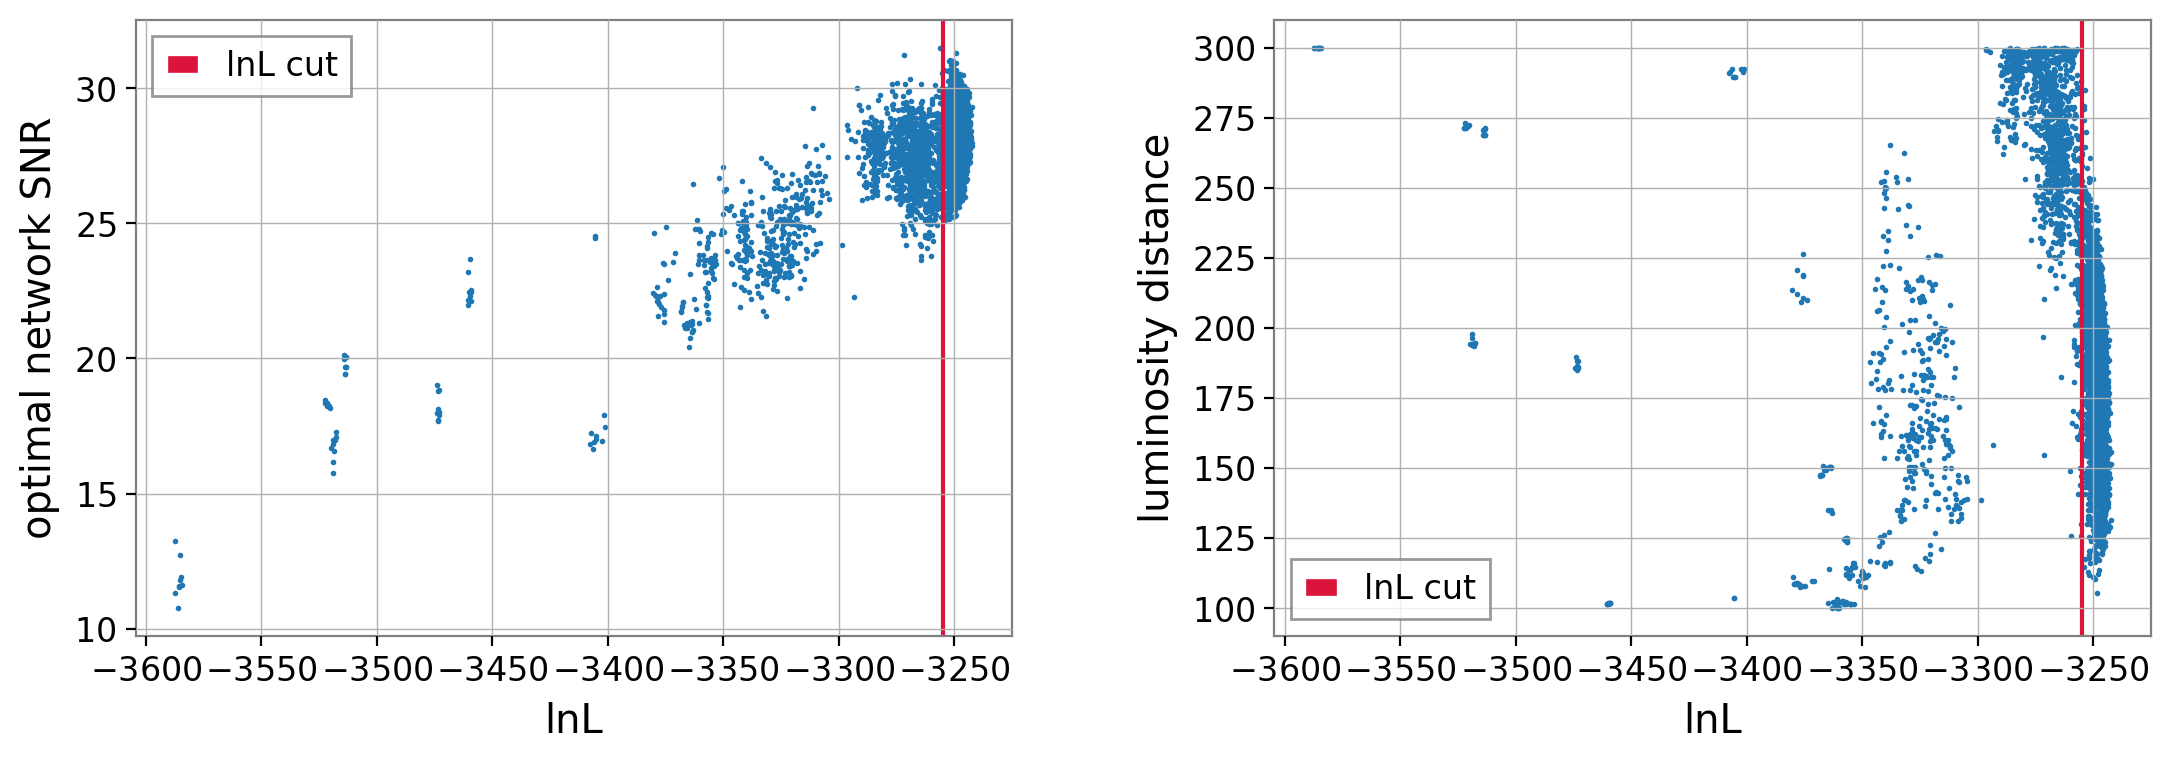

In [44]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.scatter(TD_posterior['ln_likelihood'], TD_posterior['network_optimal_SNR'], s=1)
plt.xlabel('lnL')
plt.ylabel('optimal network SNR')
plt.axvline(lnL_CUT, color='crimson', label='lnL cut')
plt.legend()

plt.subplot(122)
plt.scatter(TD_posterior['ln_likelihood'], TD_posterior['luminosity_distance'], s=1)
plt.xlabel('lnL')
plt.ylabel('luminosity distance')
plt.axvline(lnL_CUT, color='crimson', label='lnL cut')
plt.legend()

plt.subplots_adjust(wspace=0.3)
plt.show()

## Some checks: 

First, check for convergence by plotting the run from which `250804_output` was launched:

In [14]:
run2 = '250804_output'
TD_posterior2 = load_TD_results(run2)[0]

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


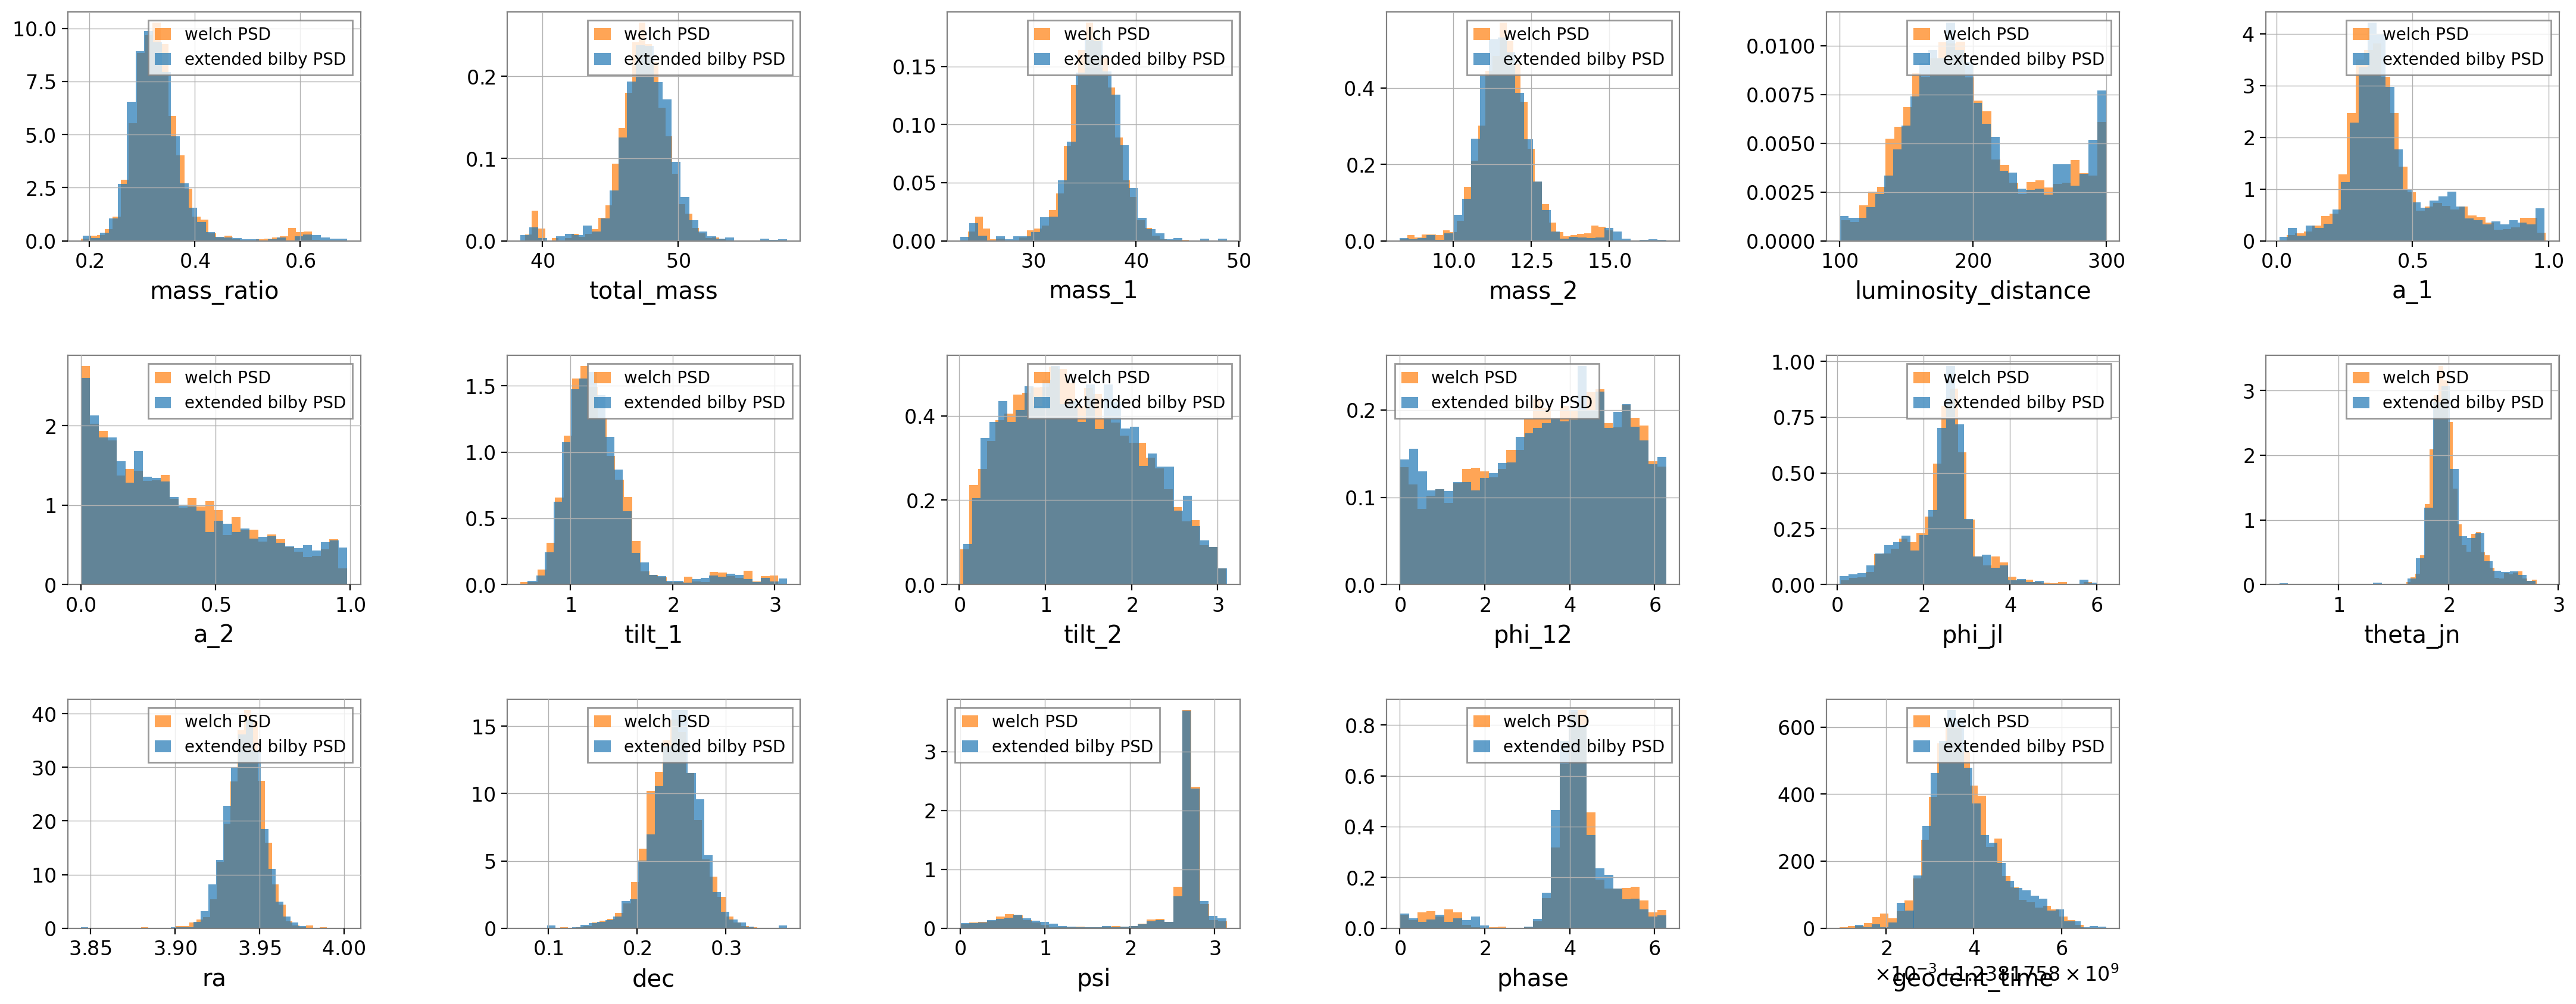

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    ax.hist(TD_posterior2[key_transform[k]], **hist_kws, color='C1', alpha=0.7, label='welch PSD')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='extended bilby PSD')
        
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

And plot the MCMC chains themselves:

In [16]:
import emcee
f = f'output/{run}/full_0.0seconds/full_0.0seconds.h5'
backend = emcee.backends.HDFBackend(f, read_only=True) 

thin = 500
chain = backend.get_chain(thin=thin)

In [17]:
# Transform chains to physical space
_chain_phys = lm.samp_to_phys([chain[:,:,i].flatten() for i in range(chain.shape[-1])])

_chain_phys['mass_1'], _chain_phys['mass_2'] = utils.m1m2_from_mtotq(_chain_phys['total_mass'], _chain_phys['mass_ratio'])
_chain_phys['chi_eff'] = utils.chi_effective(
    _chain_phys['mass_1'], _chain_phys['spin1_magnitude'], _chain_phys['spin1_z']/_chain_phys['spin1_magnitude'], 
    _chain_phys['mass_2'], _chain_phys['spin2_magnitude'], _chain_phys['spin2_z']/_chain_phys['spin1_magnitude']
)
_chain_phys['chi_p'] = utils.chi_precessing(
    _chain_phys['mass_1'], _chain_phys['spin1_magnitude'], _chain_phys['spin1_z']/_chain_phys['spin1_magnitude'], 
    _chain_phys['mass_2'], _chain_phys['spin2_magnitude'], _chain_phys['spin2_z']/_chain_phys['spin1_magnitude']
)

chain_phys = {k:v.reshape(chain.shape[0], chain.shape[1]) for k,v in _chain_phys.items()}

chain_phys['polarization'] = chain_phys['polarization'] % np.pi
jumps_pol = np.where(np.abs(np.diff(chain_phys['polarization'])) > 0.5*np.pi) # get rid of jaggedess in plot from wrapping
chain_phys['polarization'][jumps_pol] = np.nan

chain_phys['phase'] = np.where(chain_phys['phase'] < 0, chain_phys['phase'] + 2 * np.pi, chain_phys['phase'])
jumps_phase = np.where(np.abs(np.diff(chain_phys['phase'])) > np.pi)  # get rid of jaggedess in plot from wrapping
chain_phys['phase'][jumps_phase] = np.nan

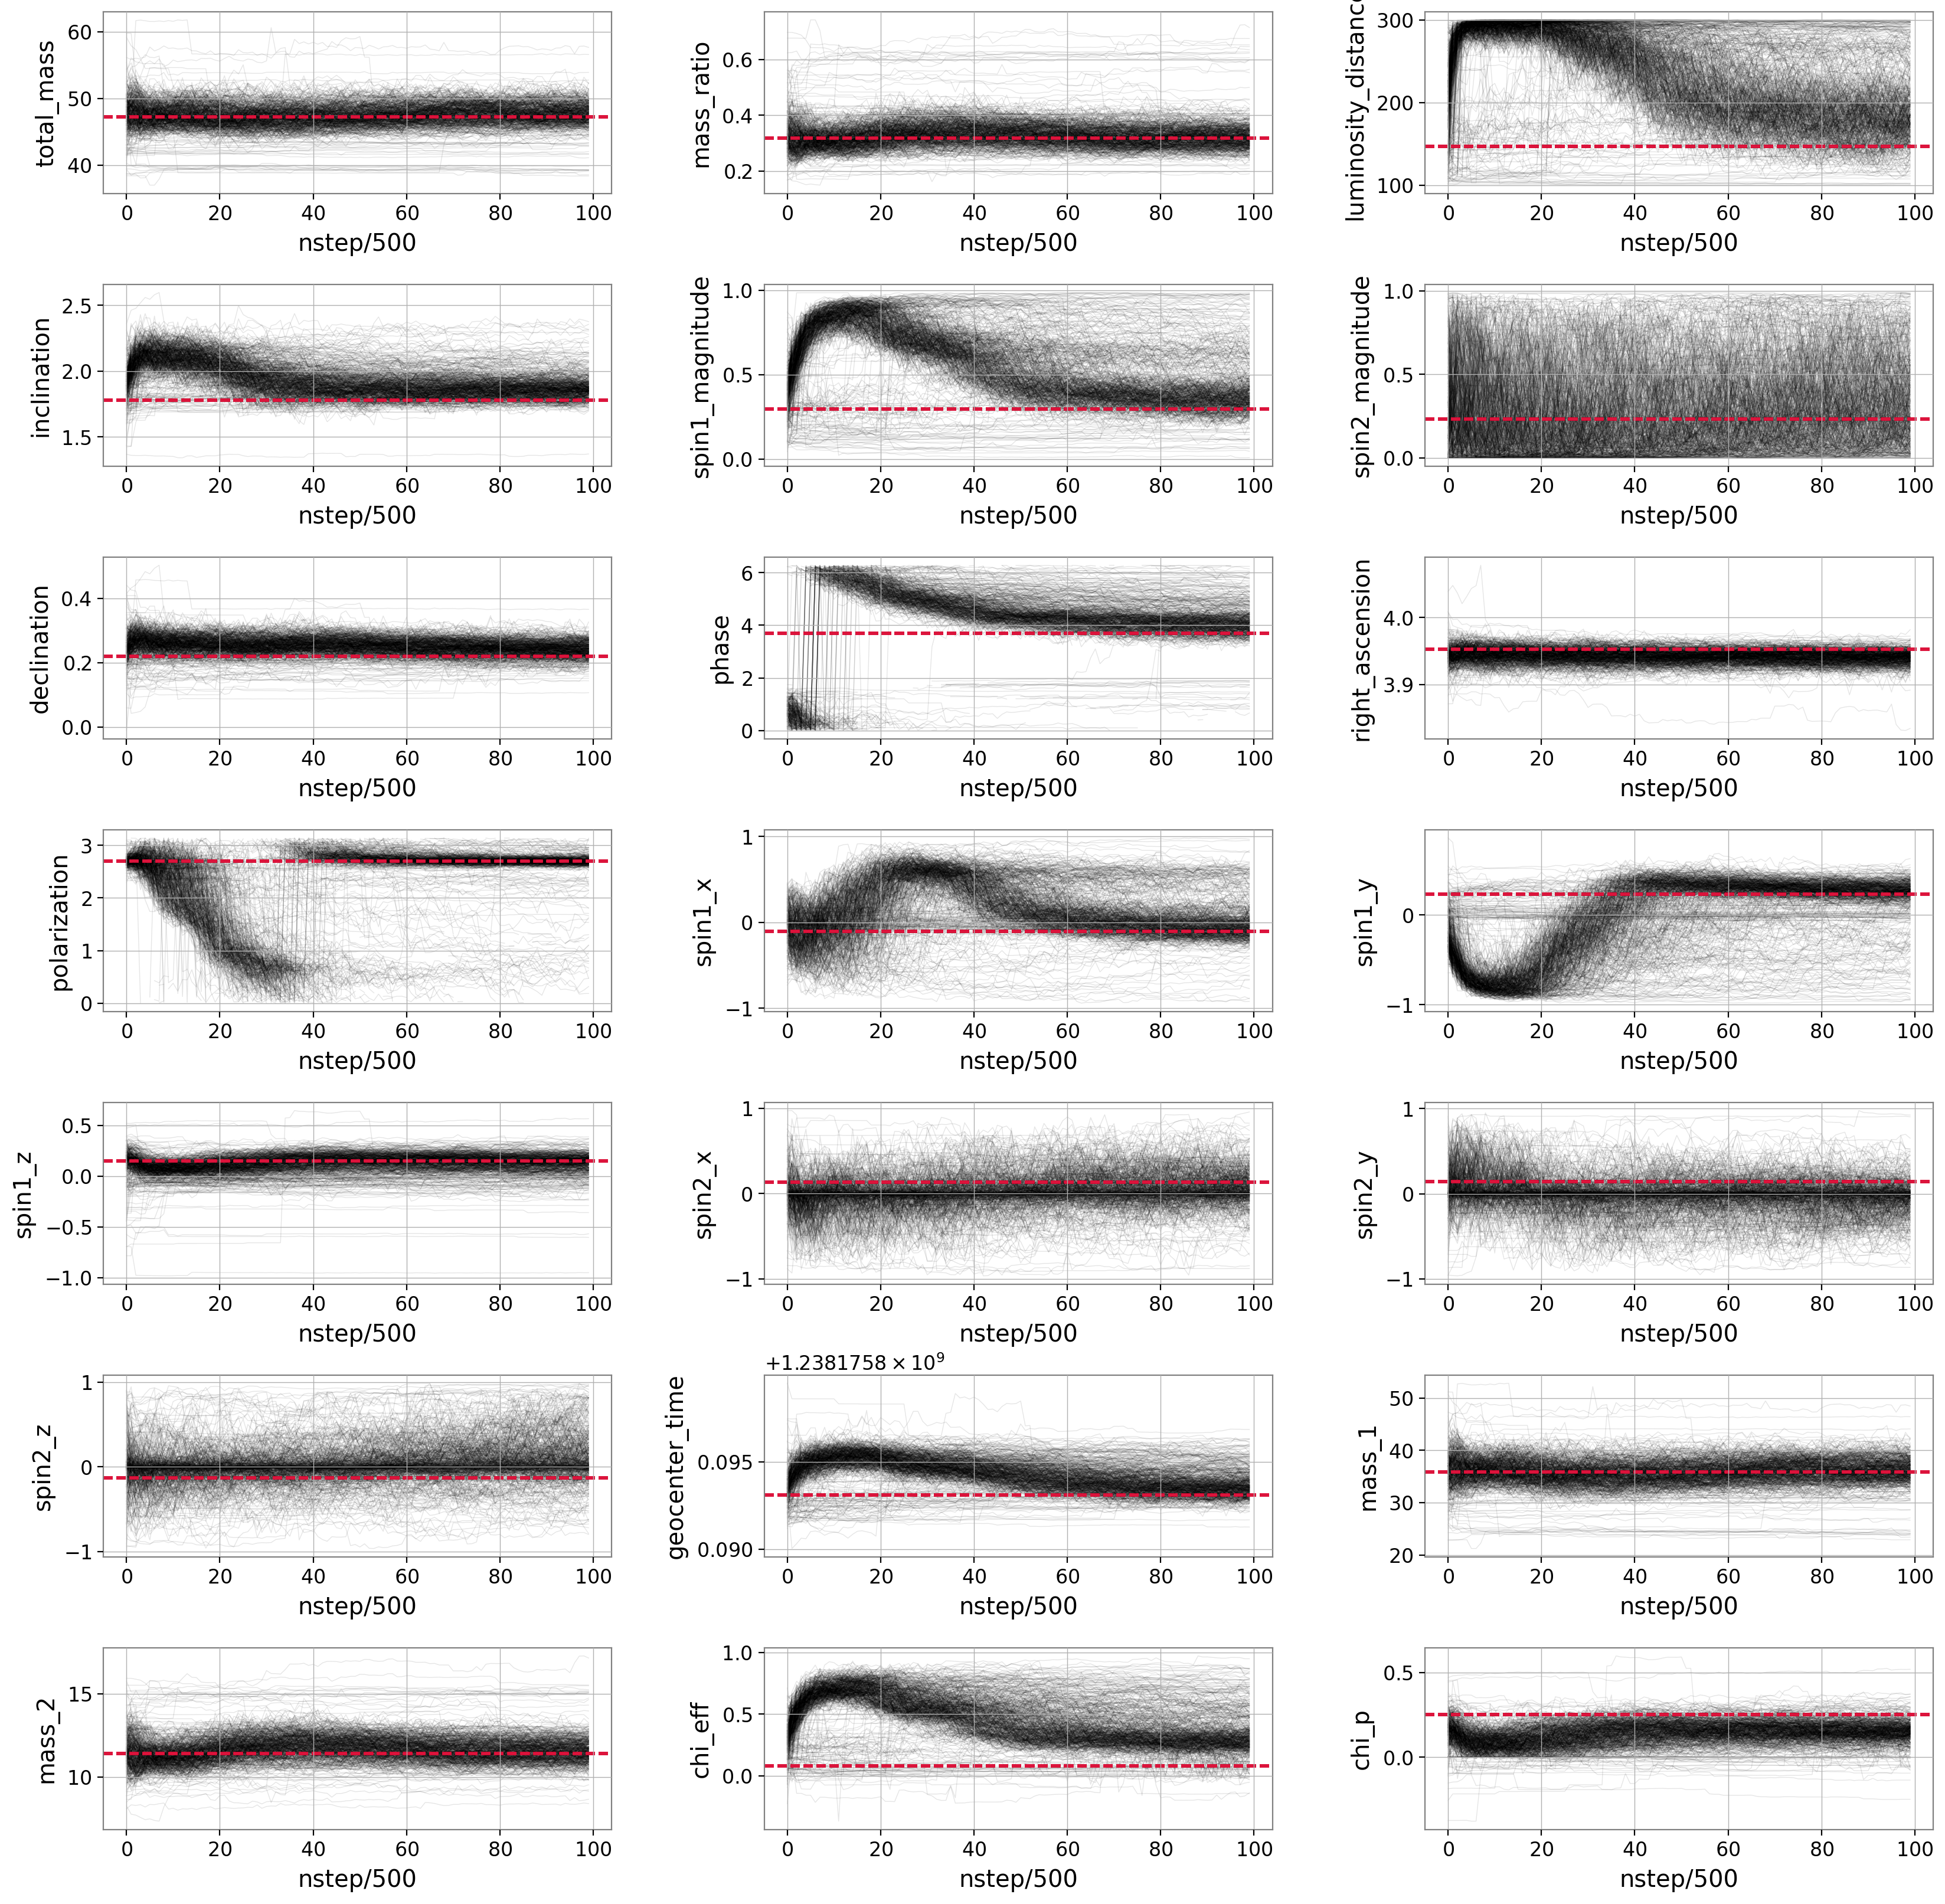

In [18]:
# Plot the chains (black) and the truth (red)
fig, axes = plt.subplots(7,3,figsize=(20,20)) 

for param,ax in zip(chain_phys.keys(), axes.flatten()):
    for ch in chain_phys[param].T:
        ax.plot(ch, color='k', lw=0.5, alpha=0.1)
        ax.axhline(reference_parameters_transformed[param], color='crimson', ls='--')
    ax.set_ylabel(param)
    ax.set_xlabel(f'nstep/{thin}')
    
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

### Plot waveforms

In [19]:
# Load waveforms
wfs = waveform_h5s.load_waveform_h5py(f'output/{run}/waveforms/full_waveforms.h5')

In [20]:
# Whiten waveforms
L_dict = {}
for ifo in lm.ifos:
    C = sl.toeplitz(lm.rho_dict[ifo])
    L_dict[ifo] = sl.cholesky(C,lower=True)
    
wfs_whitened = utils.whiten_wfs_TD(wfs['samples'], L_dict)

100%|██████████| 1000/1000 [00:16<00:00, 62.29it/s]


In [21]:
# Get truth (injection)
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)

# Get whitened injection
injection_dict_wh = utils.whitenData_dict_TD(injection_dict, lm)

# Get whitened strain 
data_dict_wh =  utils.whitenData_dict_TD(lm.data_dict, lm)

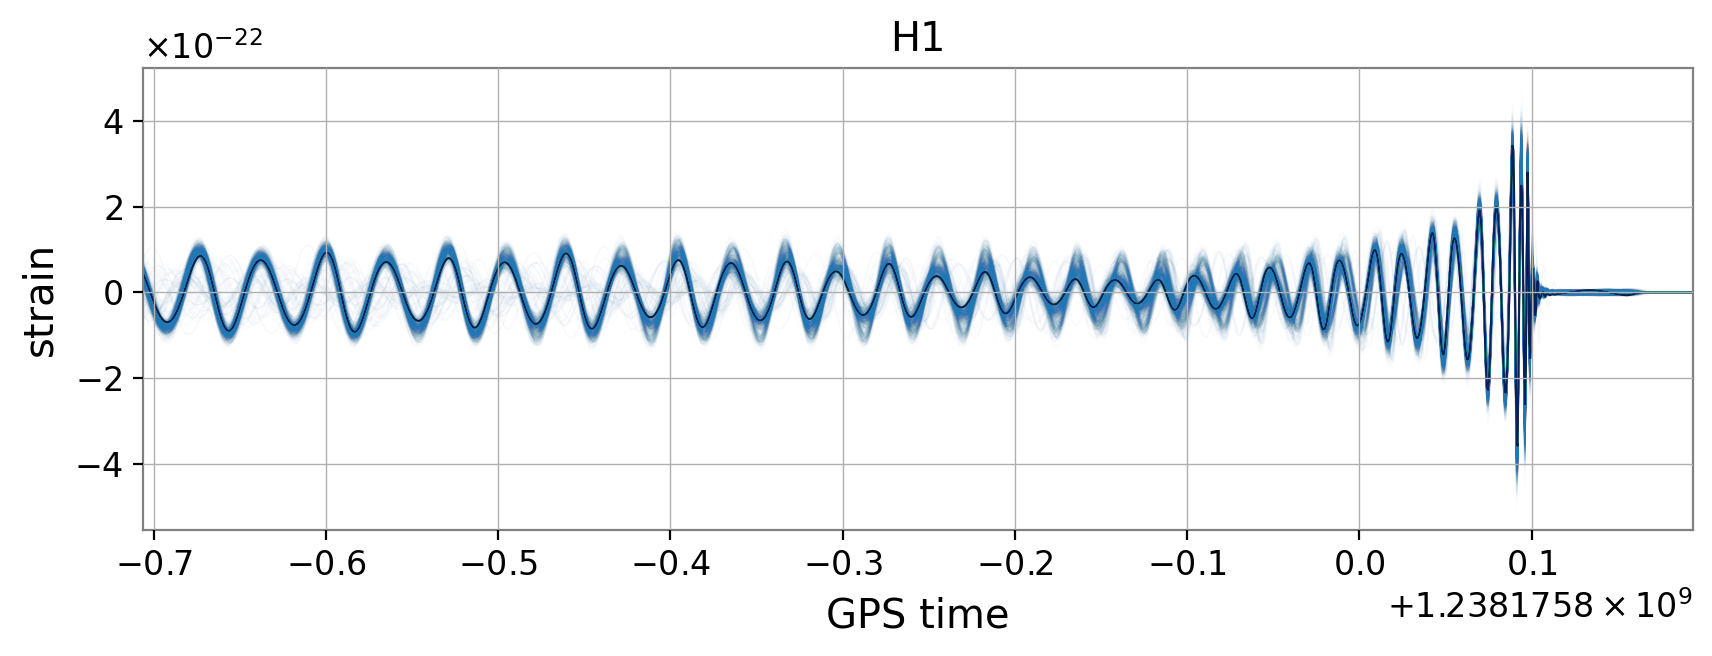

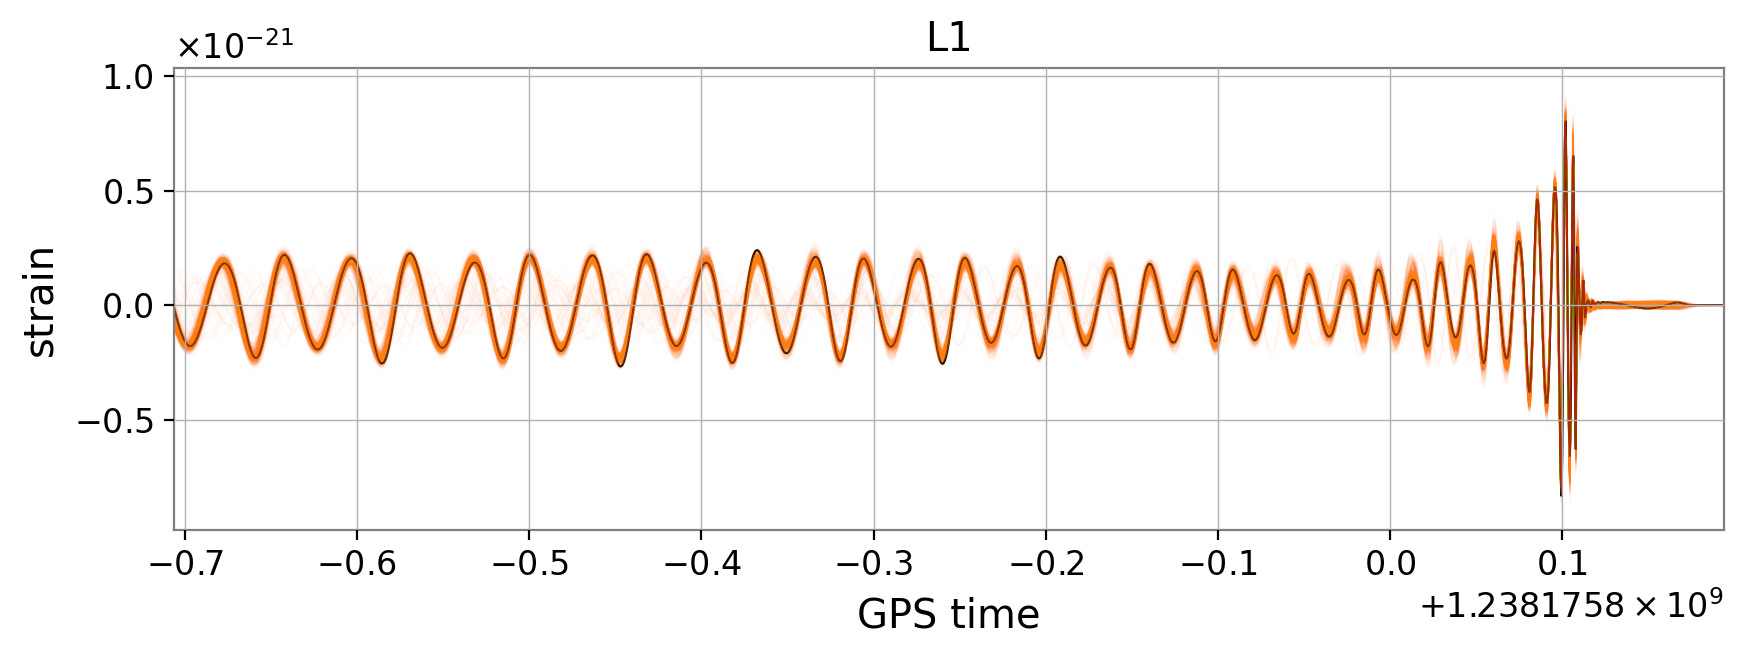

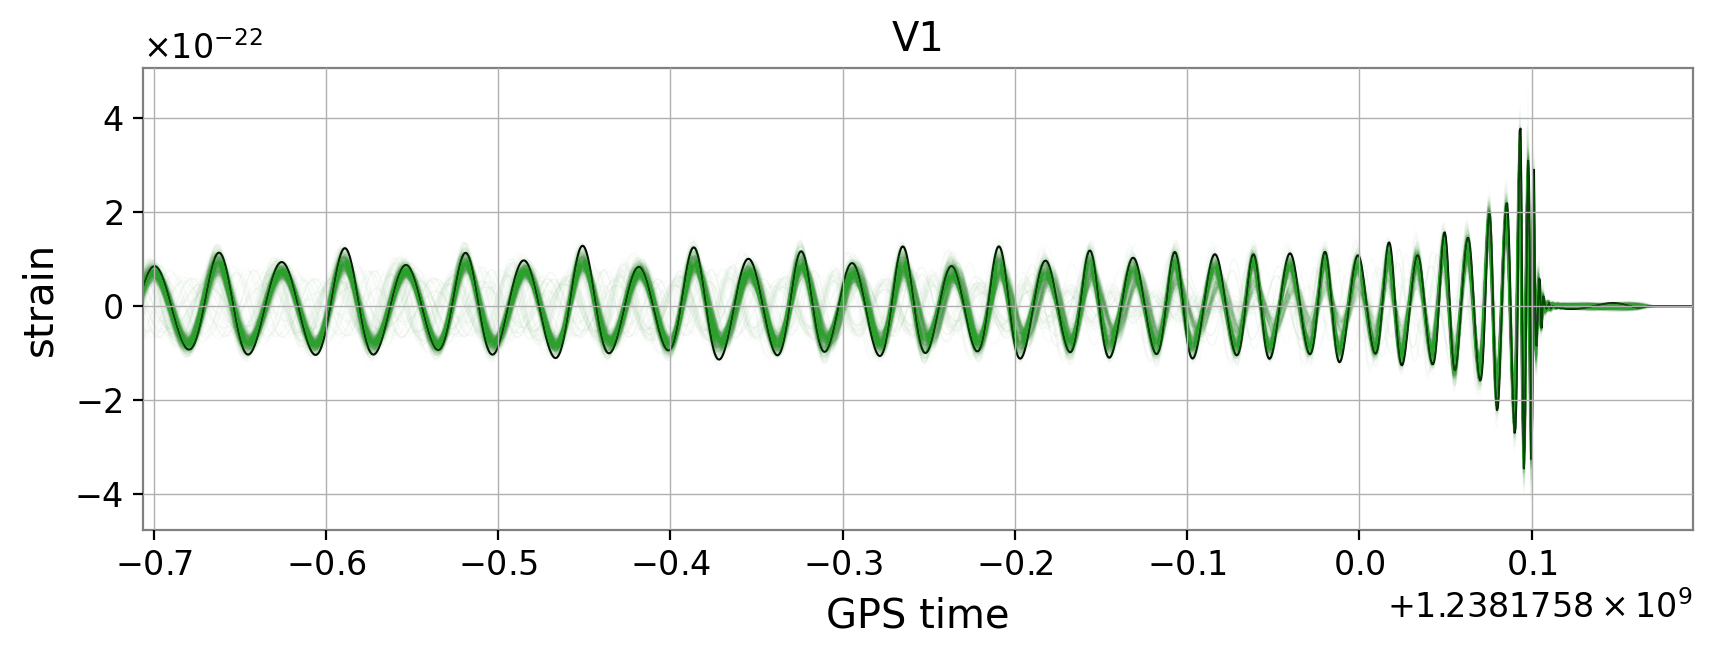

In [47]:
# Plot colored
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    plt.plot(lm.time_dict[ifo], injection_dict[ifo], color='k', zorder=0, lw=0.75)
    
    # full
    for j in range(len(wfs['samples'])):
        plt.plot(lm.time_dict[ifo], wfs['samples'][j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-0.8, lm.reference_time+0.1)
    plt.xlabel('GPS time')
    plt.ylabel('strain')
    plt.show()

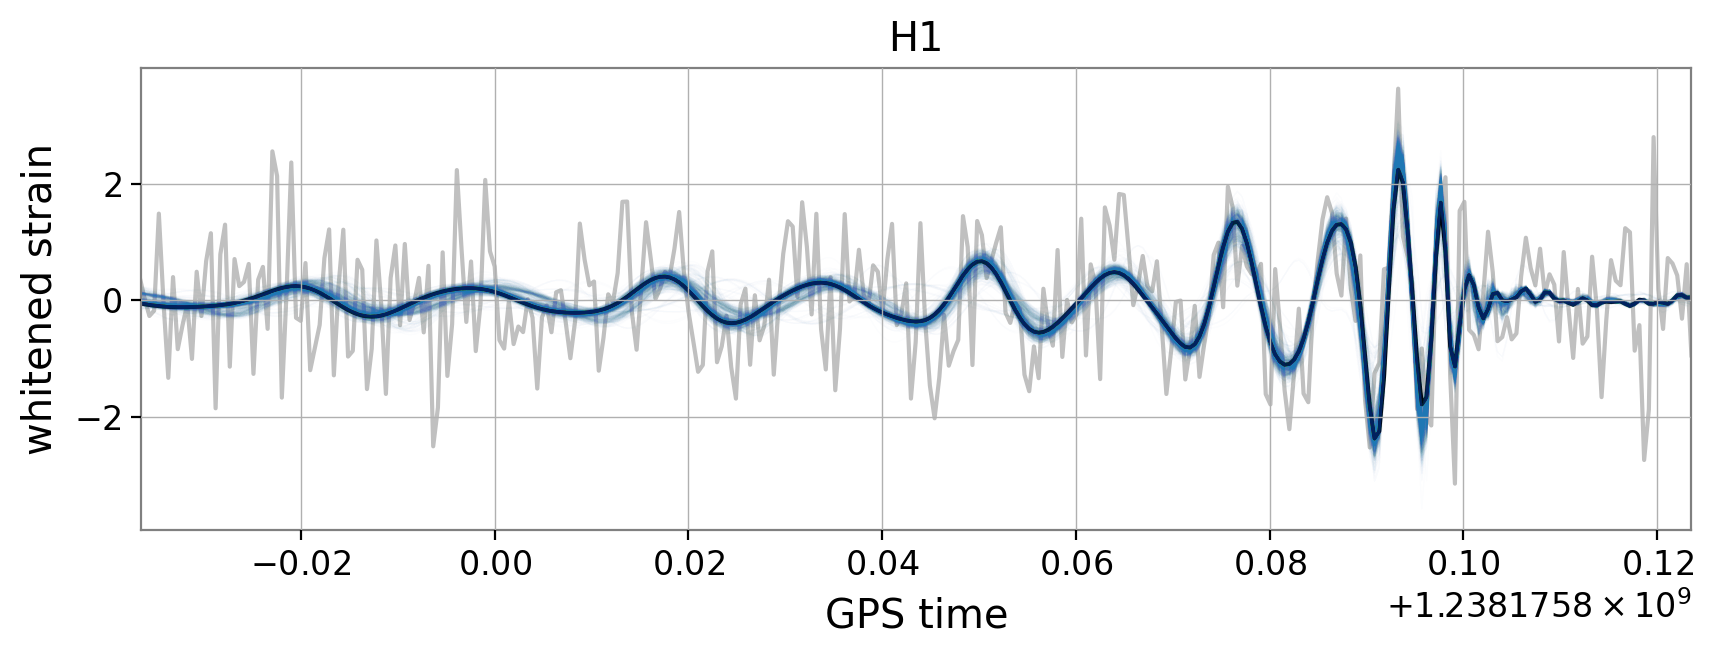

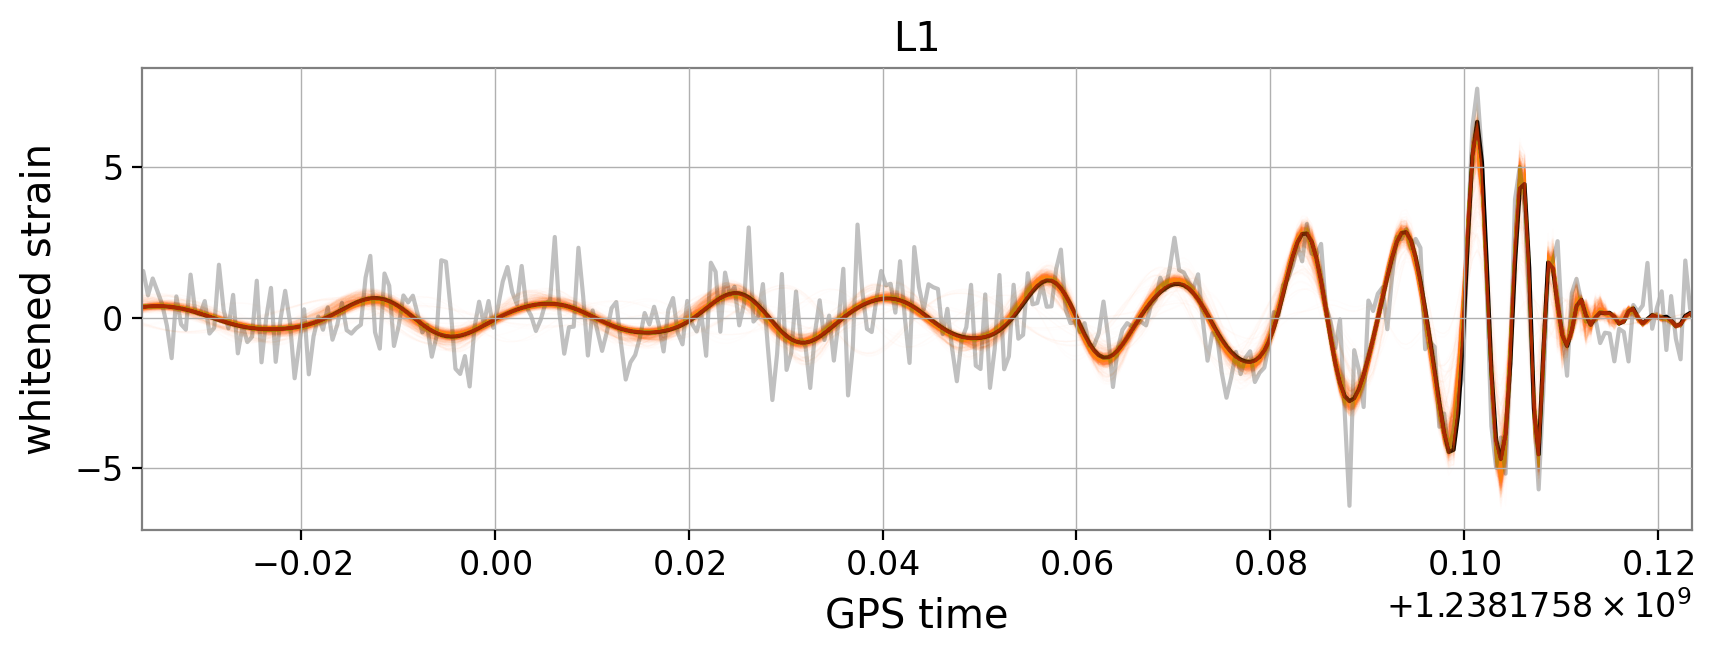

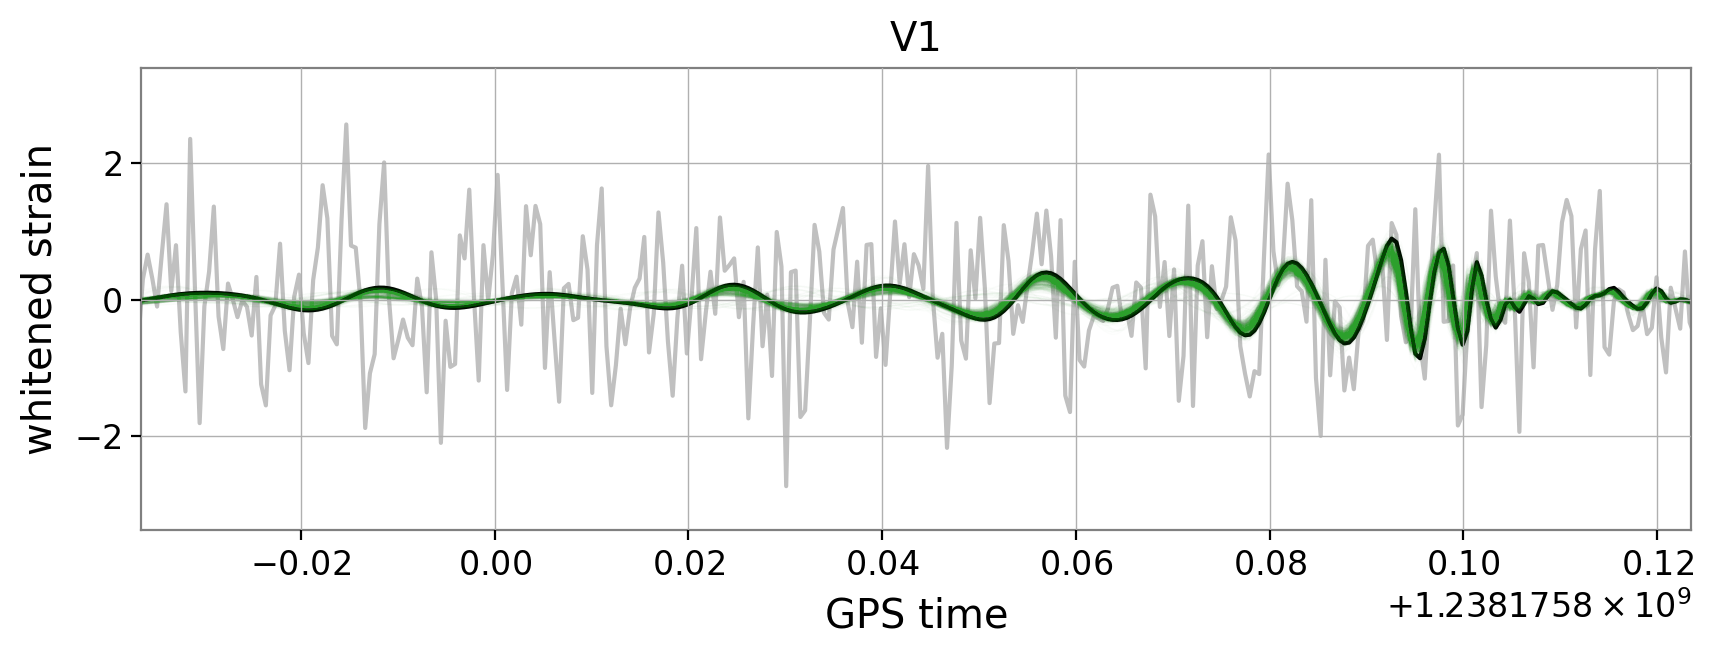

In [32]:
# Plot whitened
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    
    plt.plot(lm.time_dict[ifo], injection_dict_wh[ifo], color='k', zorder=1)
    plt.plot(lm.time_dict[ifo], data_dict_wh[ifo], color='silver', zorder=0)

    # full
    for j in range(len(wfs_whitened)):
        plt.plot(lm.time_dict[ifo], wfs_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01, zorder=2)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-0.13, lm.reference_time+0.03)
    plt.xlabel('GPS time')
    plt.ylabel('whitened strain')
    plt.show()

Are the residuals gaussian?

In [24]:
# Gaussian distribution
mean = 0 
std_dev = 1
x_values = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 500)
pdf_values = norm.pdf(x_values, loc=mean, scale=std_dev)

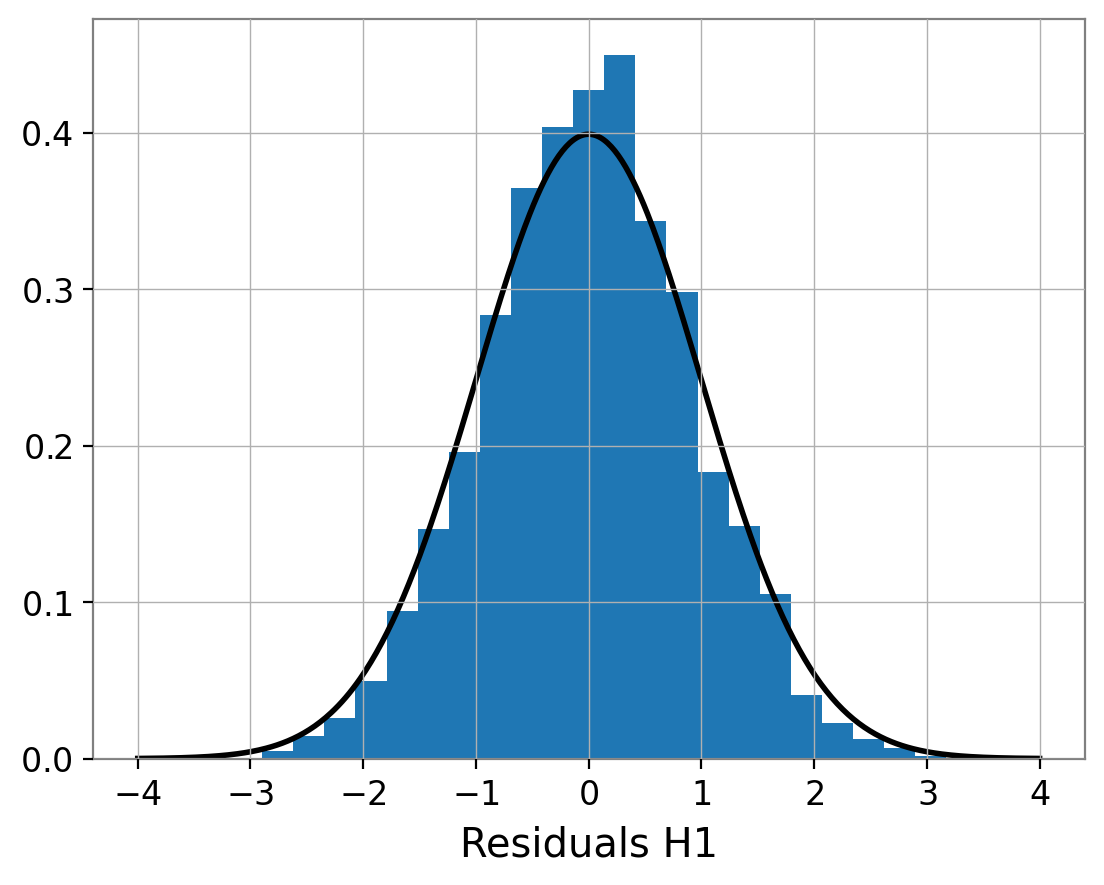

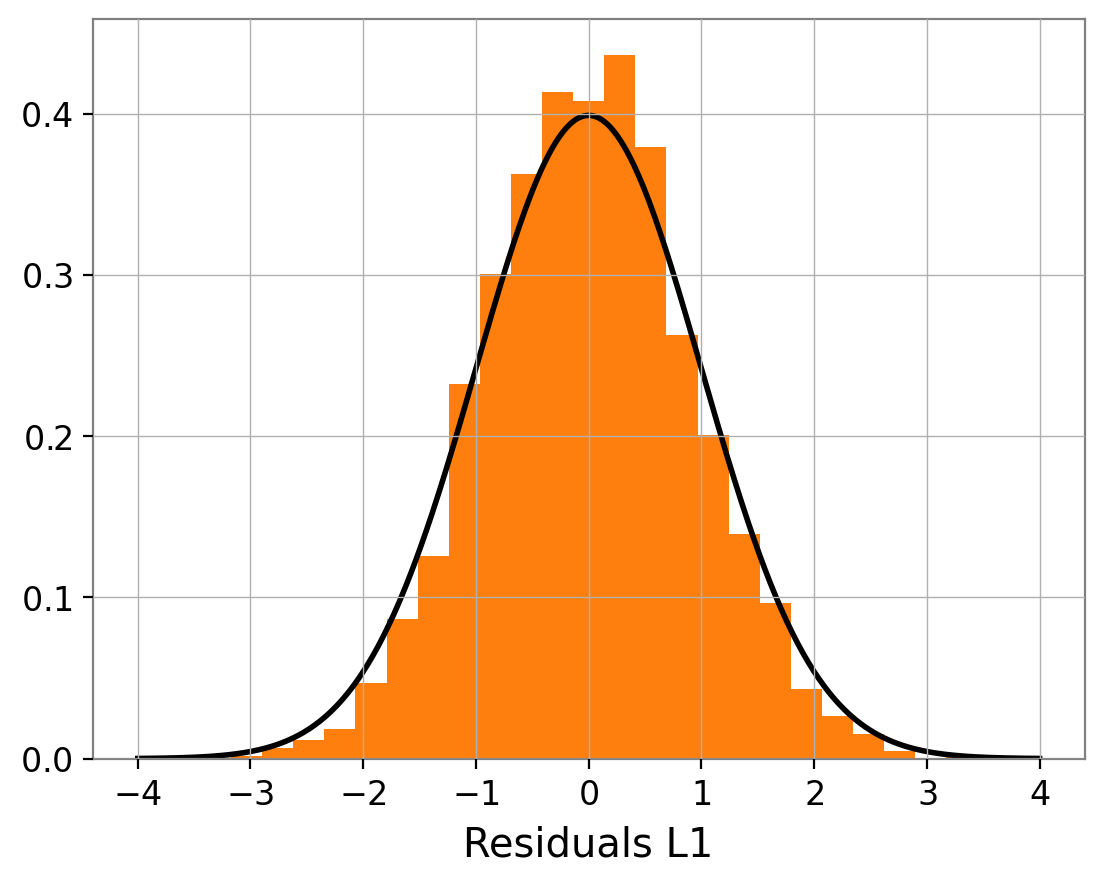

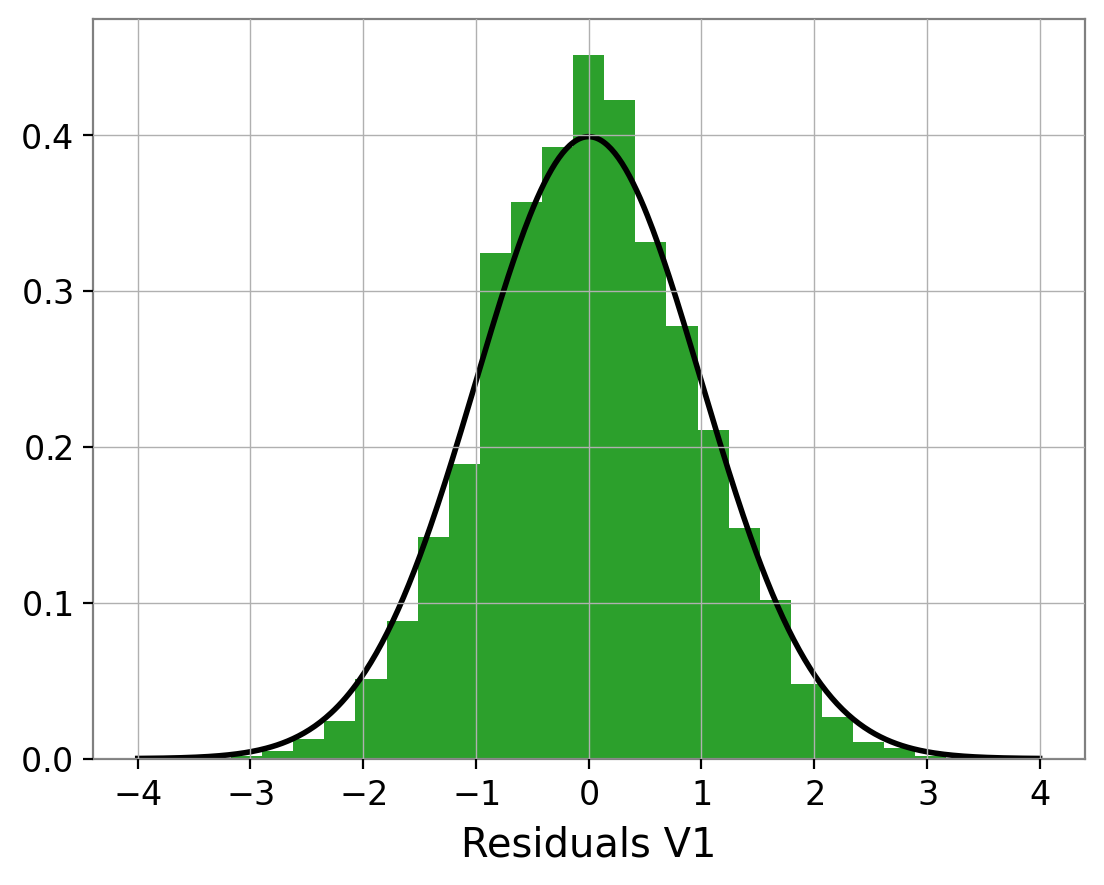

In [28]:
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo]
    strain = data_dict_wh[ifo]

    plt.figure()

    residuals = []
    for j in range(len(wfs_whitened)):
        wf =  wfs_whitened[j][ifo]
        residuals.append( strain - wf )

    flt_res = np.asarray(residuals).flatten()
    plt.hist(flt_res, color=f'C{i}', bins=np.linspace(-4,4,30), density=True)

    plt.plot(x_values, pdf_values, color='k', lw=2)
    plt.xlabel(f'Residuals {ifo}')
    plt.show()